# Introduction

---

## 1. Iterative refinement: coarse to fine as multi-task learning

In our previous model with an autoencoder with partial convolutions, we observed reasonably good reconstruction, though we noted that the output image was blurry and occasionally suffered from discolouration.

While one cause from that is likely to do with the choice of L2 as a loss function - since its gradients promote approximate estimates rather than exact - another can be due to the way the model is learning. We saw feature maps in the downsampling arm captured largely feature and later semantic information

## 2. Staggered loss functions

# Initialization

## Imports

In [1]:
# functional
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import time

# visualization
import matplotlib.pyplot as plt

# images
from skimage import io
from skimage import transform

# metrics
import torchmetrics


/home/e/e0425222/miniconda3/envs/env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Import custom methods

In [2]:
import sys
sys.path.append("/home/e/e0425222/CS4243/")
from utils.dataset_utils.AnimalDataset import AnimalDataset
from utils.train_utils.train_utils import visualize_results, sample_batch

# Model

## Define model
Here, we define five main classes to encapsulate the logic:
 1. `GatedConv2d` 
 2. `GatedConv2dBlock`
 3. `Conv2dBlock`
 4. `Conv2dPixelShuffleUpsample`
 5. `GatedConvUNet` class that encapsulates the main model.

 

In [3]:
class GatedConv2d(nn.Module):

    """
    This class implements a gated convolution. It works by applying a convolution filter 
    to the input feature tensor, then using the sigmoid function to map each score to a 
    pixel validity weight. The weights are then multiplied to the activation map from a 
    separate convolution filter.
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(GatedConv2d, self).__init__()
        self.image_conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.gate_conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_tensor, return_mask = False):

        mask = self.sigmoid(self.gate_conv(input_tensor))
        x = self.image_conv(input_tensor)
        x = torch.mul(x, mask) # apply mask

        if return_mask:
            return x, mask

        return x


class GatedConv2dBlock(nn.Module):
    """
    This class encapsulates the following:
    GatedConv2d -> BN -> activation
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, activation = nn.ReLU, p = 0.2):
        super(GatedConv2dBlock, self).__init__()
        self.conv = GatedConv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(num_features = out_channels)
        self.activation = activation()
    
    def forward(self, input_tensor, return_mask = False):
        if return_mask:
            x, mask = self.conv(input_tensor)
        else:
            x = self.conv(input_tensor)

        x = self.bn(x)
        x = self.activation(x)

        if return_mask:
            return x, mask
            
        return x


class Conv2dBlock(nn.Module):
    """
    This class encapsulates the following:
    Conv2d -> BN -> activation
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, activation = nn.ReLU, p = 0.2):
        super(Conv2dBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(num_features = out_channels)
        self.activation = activation()
    
    def forward(self, input_tensor):
        x = self.conv(input_tensor)
        x = self.bn(x)
        x = self.activation(x)

        return x

class GatedConv2dUpsample(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, activation = nn.ReLU, scale_factor = (2,2), mode = 'nearest'):
        super(GatedConv2dUpsample, self).__init__()
        self.upsample = nn.Upsample(scale_factor = scale_factor, mode = mode)
        self.conv = GatedConv2dBlock(in_channels, out_channels, kernel_size, stride, padding, activation)

    def forward(self, input_tensor):
        x = self.upsample(input_tensor)
        x = self.conv(x)
        return x



class GatedConvAE(nn.Module):
    """
    This class encapsulates a UNet-like model with gated convolution blocks and residual skips.
    """
    
    def __init__(self, 
                 blocks_per_layer = 2,
                 in_channels = 4, 
                 hidden_channels = 32, 
                 kernel_size = 3, 
                 stride = 1, 
                 padding = 'same',
                 activation = nn.ReLU):

        super(GatedConvAE, self).__init__()

        # ===== DOWNSAMPLING =====
        
        # first convolution
        self.first = GatedConv2dBlock(in_channels, hidden_channels, kernel_size, stride, padding, activation)

        # convolutions
        self.down_1 = nn.ModuleList(
            [GatedConv2dBlock(hidden_channels, hidden_channels, kernel_size, stride, padding, activation) 
             for i in range(blocks_per_layer)])

        self.down_2 = nn.ModuleList(
            [GatedConv2dBlock(hidden_channels, hidden_channels, kernel_size, stride, padding, activation) 
             for i in range(blocks_per_layer)])        

        self.down_3 = nn.ModuleList(
            [GatedConv2dBlock(hidden_channels, hidden_channels, kernel_size, stride, padding, activation) 
             for i in range(blocks_per_layer)])  
        
        # downsampling by convolution
        self.downtransform_1 = GatedConv2dBlock(hidden_channels, hidden_channels, kernel_size = 4, stride = 2, padding = 1, activation = activation)
        self.downtransform_2 = GatedConv2dBlock(hidden_channels, hidden_channels, kernel_size = 4, stride = 2, padding = 1, activation = activation)
        self.downtransform_3 = GatedConv2dBlock(hidden_channels, 2 * hidden_channels, kernel_size = 4, stride = 2, padding = 1, activation = activation)

        # ===== MIDDLE =====
        
        self.middle = nn.ModuleList(
            [GatedConv2dBlock(2 * hidden_channels, 2 * hidden_channels, kernel_size, stride, padding, activation) 
             for i in range(blocks_per_layer)])  
        

        # ===== UPSAMPLING =====
        # upsample and convolution, always doubling
        self.uptransform_1 = GatedConv2dUpsample(2 * hidden_channels, hidden_channels, kernel_size, stride, padding, activation, scale_factor = (2,2), mode = 'nearest')
        self.uptransform_2 = GatedConv2dUpsample(hidden_channels, hidden_channels, kernel_size, stride, padding, activation, scale_factor = (2,2), mode = 'nearest')
        self.uptransform_3 = GatedConv2dUpsample(hidden_channels, hidden_channels, kernel_size, stride, padding, activation, scale_factor = (2,2), mode = 'nearest')

        # convolutions
        self.up_1 = nn.ModuleList(
            [GatedConv2dBlock(hidden_channels, hidden_channels, kernel_size, stride, padding, activation) 
             for i in range(blocks_per_layer)])
        
        self.up_2 = nn.ModuleList(
            [GatedConv2dBlock(hidden_channels, hidden_channels, kernel_size, stride, padding, activation) 
             for i in range(blocks_per_layer)])
        
        self.up_3 = nn.ModuleList(
            [GatedConv2dBlock(hidden_channels, hidden_channels, kernel_size, stride, padding, activation) 
             for i in range(blocks_per_layer)])

        # final scores
        self.final = nn.Conv2d(hidden_channels, 3, kernel_size, stride, padding)

    def forward(self, input_tensor):
        
        # ===== DOWNSAMPLING =====

        # first layer
        x1 = self.first(input_tensor)
        for l in self.down_1:
            x1 = x1 + l(x1) # residual skips
        
        # second layer 
        x2 = self.downtransform_1(x1)
        for l in self.down_2:
            x2 = x2 + l(x2)

        # third layer 
        x3 = self.downtransform_2(x2)
        for l in self.down_3:
            x3 = x3 + l(x3)

        # ===== BOTTOM ====
        x = self.downtransform_3(x3)
        for l in self.middle:
            x = x + l(x)

        # ===== UPSAMPLING =====

        # first layer
        x = self.uptransform_1(x)
        for l in self.up_1:
            x = x + l(x)
        
        # second layer 
        x = self.uptransform_2(x)
        for l in self.up_2:
            x = x + l(x)

        # third layer
        x = self.uptransform_3(x)
        for l in self.up_3:
            x = x + l(x)

        # ===== FINAL =====
        x = self.final(x)
        return x 


    def summary(self, verbose = False):
        count = 0
        if verbose:
            print(self)

        for name, params in self.named_parameters():
            num_params = params.flatten().size()[0]
            count += num_params
            if verbose:
                print(f"\nlayer: {name}")
                print(f"number of params: {num_params}")
                print(f"params shape: {params.size()}")

        print(f"model has {count/1e6} million parameters")


class GatedConvAEIterative(nn.Module):
    
    def __init__(self, 
                 blocks_per_layer = 2,
                 in_channels = 4, 
                 hidden_channels = 32, 
                 kernel_size = 3, 
                 stride = 1, 
                 padding = 'same',
                 activation = nn.ReLU):
        super(GatedConvAEIterative, self).__init__()

        self.coarse = GatedConvAE(blocks_per_layer,
                                  in_channels, 
                                  hidden_channels, 
                                  kernel_size, 
                                  stride, 
                                  padding,
                                  activation)

        self.fine = GatedConvAE(blocks_per_layer,
                                in_channels + 3, 
                                hidden_channels, 
                                kernel_size, 
                                stride, 
                                padding,
                                activation)

    def forward(self, input_tensor, both = True):

        coarse = self.coarse(input_tensor)
        fine = self.fine(coarse)

        if not both:
            return fine
            
        return coarse, fine
        

    def summary(self, verbose = False):
        count = 0
        if verbose:
            print(self)

        for name, params in self.named_parameters():
            num_params = params.flatten().size()[0]
            count += num_params
            if verbose:
                print(f"\nlayer: {name}")
                print(f"number of params: {num_params}")
                print(f"params shape: {params.size()}")

        print(f"model has {count/1e6} million parameters")


## Initialize model
Note that there is a significant difference in the depth (and thus, number of parameters) in the model. There are equivalently 17 layers in this model, relative to the 10 in the original CNN model.

In [4]:
# model parameters
blocks_per_layer = 1
in_channels = 4
hidden_channels = 32
kernel_size = 3
stride = 1
padding = 'same'
activation = nn.PReLU

# create model
model = GatedConvAEIterative(blocks_per_layer,
                            in_channels, 
                            hidden_channels, 
                            kernel_size, 
                            stride, 
                            padding,
                            activation)
model.summary(verbose = False)


model has 0.790434 million parameters


## Save model

In [5]:
MODEL_FOLDER = "/home/e/e0425222/CS4243/model_weights/GatedConvAEIterative"

In [6]:
# save path
MODEL_NAME = "GatedConvAEIterative_3downup_1blocksperlayer_32hidden_prelu"
SAVE_PATH = f"{MODEL_FOLDER}/{MODEL_NAME}"

# save
torch.save(model.state_dict(), SAVE_PATH)

# sanity check
loaded = GatedConvAEIterative(blocks_per_layer,
                             in_channels, 
                             hidden_channels, 
                             kernel_size, 
                             stride, 
                             padding,
                             activation)

loaded.load_state_dict(torch.load(SAVE_PATH))
loaded.summary()
del loaded

model has 0.790434 million parameters


# Training Details
For training, we define all details here, and wrap it into two main dictionaries, `training_params` and `metrics`.

## Custom loss function

In [7]:
def mask_segmented_loss(output, target, mask, loss_function = nn.functional.mse_loss):
    """
    This is a custom functional loss function that considers where the mask is, and
    applies the loss function seperately. 
    """
    
    LOSS = loss_function # can use l1 loss or coarse to fine refinement


    def weighted_sum():
        MASKED_WEIGHT = 10
        UNMASKED_WEIGHT = 1

        # weights by mask, unmasked as 1
        masked_weights = (mask - 1) * -1 * MASKED_WEIGHT # invert the mask in a differentiable way
        unmasked_weights = mask * UNMASKED_WEIGHT
        
        # weighted sum
        loss_masked = LOSS(output, target, reduction = 'none')
        loss_unmasked = LOSS(output, target, reduction = 'none')
        loss = torch.mul(loss_masked, masked_weights) + torch.mul(loss_unmasked, unmasked_weights)
        loss = torch.mean(loss)
        return loss

    def only_masked():
        loss = LOSS(output, target, reduction = 'none')
        loss = torch.mul(loss, (-mask + 1))
        loss = torch.sum(loss)/torch.sum(-mask + 1)
        return loss

    # only masked
    loss = weighted_sum()

    return loss

def coarse_fine_mask_segmented_loss(coarse_output, fine_output, target, mask):

    COARSE_WEIGHT = 1
    FINE_LOSS = 1

    coarse_loss = mask_segmented_loss(coarse_output, target, mask, loss_function = nn.functional.mse_loss) * COARSE_WEIGHT
    fine_loss = mask_segmented_loss(fine_output, target, mask, loss_function = nn.functional.l1_loss) * FINE_LOSS

    return coarse_loss + fine_loss


## Training parameters


In [8]:
# device
device = 'cuda:1'  
model = model.to(device)

# define training parameters
num_epochs = 20
batch_size = 32

# optimizer parameters
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.5, patience = 1, threshold = 1e-6)

# loss function 
loss_function = coarse_fine_mask_segmented_loss

# wrap into dictionary
training_params = {
    "num_epochs" : num_epochs,
    "batch_size" : batch_size, 
    "learning_rate": learning_rate,
    "optimizer" : optimizer,
    "scheduler" : scheduler,
    "schedule_every" : 1,
    "loss_function" : loss_function,
    "save_path" : SAVE_PATH
}



## Metrics

In [9]:
# define metrics
metrics = {
    "Multiscale structural similarity index measure" : torchmetrics.functional.multiscale_structural_similarity_index_measure,
    "Peak SnR" : torchmetrics.functional.peak_signal_noise_ratio,
    "L2 loss" : nn.functional.mse_loss,
    "L1 loss" : nn.functional.l1_loss
}

## Load Frogs dataset

In [10]:
dataset = AnimalDataset(index_file_path = "/home/e/e0425222/CS4243/dataset/frogs/frogs_wanted_indices_url.txt",
                        root_dir_path = "/home/e/e0425222/CS4243/dataset/frogs/images",
                        local_dir_path = "/home/e/e0425222/CS4243/dataset/frogs/preprocessed",
                        file_prefix = "frog_",
                        image_dimension = 256,
                        concat_mask = True)

dataset.initialize()

# train-test split
VALID_SIZE = 0.2
NUM_WORKERS = 2

indices = torch.arange(len(dataset))
train_indices, validation_indices = train_test_split(indices, test_size = VALID_SIZE)
train_dataset = Subset(dataset, train_indices)
validation_dataset = Subset(dataset, validation_indices)


Cleaning ...
Cleaning completed. Dropped 1 files. Took 0.8366412480672201 min
The row indices dropped were [3839]


In [11]:
# sample_batch(dataset, sample_size = 16)
# sample_batch(train_dataset, sample_size = 16)
# sample_batch(validation_dataset, sample_size = 16)

# Training

## Helper functions

In [12]:
def train_epoch(model, device, train_dataloader, training_params : dict, metrics : dict):
    """
    This method encapsulates the training of a given model for one epoch. 
    
    @param model : nn.Module                        Model to be trained.
    @param device : str                             Device to be trained on.
    @param train_dataloader : nn.data.DataLoader    DataLoader object to load batches of data.
    @param training_params : dict                   Dictionary object mapping names of 
                                                    training utilities to their respective objects.
                                                    Required are "batch_size", "loss_function", 
                                                    and "optimizer". 
    @param metrics : dict                           Dictionary object mapping names of 
                                                    metrics to a functional method that 
                                                    would compute the metric value.
    """
    
    # ===== INITIALIZE =====
    # constants
    BATCH_SIZE = training_params["batch_size"]
    LOSS_FUNCTION = training_params["loss_function"]
    OPTIMIZER = training_params["optimizer"]
    BATCH_EVALUATE_EVERY = 1

    # model to device
    model = model.to(device)
    model.train()

    # epoch metrics
    running_results = {list(metrics.keys())[i] : 0.0 for i in range(len(metrics)) } 
    running_results["loss"] = 0.0

    # ===== TRAIN EPOCH =====
    num_batches = 0
    for index, batch in enumerate(train_dataloader, 1):

            # ===== INITIALIZE =====
            num_batches += 1

            # input and ground truth
            input_batched = batch["image"]
            ground_truth_batched = batch["reconstructed"]
            mask_batched = batch["mask"]

            # sanity check
            assert input_batched.shape[0] == ground_truth_batched.shape[0]

            # move tensors to device
            input_batched = input_batched.to(device)
            ground_truth_batched = ground_truth_batched.to(device)
            mask_batched = mask_batched.to(device)

            # Set the gradients to zeros
            OPTIMIZER.zero_grad()

            # ===== FORWARD PASS =====
            # reshape to channel first
            input_batched = input_batched.permute(0, 3, 1, 2)
            ground_truth_batched = ground_truth_batched.permute(0, 3, 1, 2)
            mask_batched = mask_batched.permute(0, 3, 1, 2)

            # forward pass
            input_batched.requires_grad_()
            coarse_batched, output_batched = model(input_batched)

            # ===== BACKPROP =====

            loss = LOSS_FUNCTION(coarse_batched, output_batched, ground_truth_batched, mask_batched)
            loss.backward()
            OPTIMIZER.step()

            # ===== COMPUTE STATISTICS, USING TORCH METRICS =====  
            # for each key, compute, add item to results dictionary
            running_results["loss"] += loss.detach().item()
            for key, func in metrics.items():
                running_results[key] += func(output_batched, ground_truth_batched).detach().item()

            # ===== HOUSEKEEPING =====
            del loss
            del input_batched
            del output_batched

            # print results every some batches
            if num_batches % BATCH_EVALUATE_EVERY == 0: 

                args = ""
                for key, val in running_results.items():
                    args += key + ": " + str(running_results[key]/num_batches) + "   "
                print(f"\r{num_batches}/{len(train_dataloader)}: " + args, end = '', flush = True)

    # normalise numbers by batch
    for key, val in running_results.items():
        running_results[key] /= num_batches

    return running_results



In [13]:
def evaluate_epoch(model, device, validation_dataloader, training_params : dict, metrics : dict):
    """
    This method encapsulates the evaluation of a given model for one epoch.
    
    @param model : nn.Module                            Model to be trained.
    @param device : str                                 Device to be trained on.
    @param validation_dataloader : nn.data.DataLoader   DataLoader object to load batches of data.
    @param training_params : dict                       Dictionary object mapping names of 
                                                        training utilities to their respective objects.
                                                        Required are "batch_size", "loss_function", 
                                                        and "optimizer". 
    @param metrics : dict                               Dictionary object mapping names of 
                                                        metrics to a functional method that 
                                                        would compute the metric value.
    """
    
    # ===== INITIALIZE =====
    # constants
    BATCH_SIZE = training_params["batch_size"]
    LOSS_FUNCTION = training_params["loss_function"]
    OPTIMIZER = training_params["optimizer"]

    # to device
    model = model.to(device)

    # epoch statistics
    running_results = {list(metrics.keys())[i] : 0.0 for i in range(len(metrics)) } 
    running_results["loss"] = 0.0

    # ===== EVALUATE EPOCH =====

    with torch.no_grad():
        model.eval()
        batches = 0
        for index, batch in enumerate(validation_dataloader, 1):
            
            batches += 1

            # input and ground truth
            input_batched = batch["image"]
            ground_truth_batched = batch["reconstructed"]
            mask_batched = batch["mask"]

            # move tensors to device
            input_batched = input_batched.to(device)
            ground_truth_batched = ground_truth_batched.to(device)
            mask_batched = mask_batched.to(device)

            # reshape to channel first
            input_batched = input_batched.permute(0, 3, 1, 2)
            ground_truth_batched = ground_truth_batched.permute(0, 3, 1, 2)
            mask_batched = mask_batched.permute(0, 3, 1, 2)

            # predict    
            coarse_batched, output_batched = model(input_batched)

            # evaluate
            loss = LOSS_FUNCTION(coarse_batched, output_batched, ground_truth_batched, mask_batched).detach().item()
            running_results["loss"] += loss
            
            # ===== COMPUTE STATISTICS, USING TORCH METRICS =====
            for key, func in metrics.items():
                running_results[key] += func(output_batched, ground_truth_batched).detach().item()

            args = ""
            for key, val in running_results.items():
                args += key + ": " + str(running_results[key]/batches) + "   "
            print(f"\r{batches}/{len(validation_dataloader)}: " + args, end = '', flush = True)

            # delete to ensure memory footprint
            del loss
            del input_batched
            del output_batched

    # normalise numbers by batch
    for key, val in running_results.items():
        running_results[key] /= batches

    return running_results

    

In [14]:
def train_evaluate(model, device, train_dataset, validation_dataset, training_params: dict, metrics: dict):

    """
    This method encapsulates the training and evaluation loop of a given model.
    
    @param model : nn.Module                            Model to be trained.
    @param device : str                                 Device to be trained on.
    @param train_dataloader : nn.data.DataLoader        DataLoader object to load batches of data for training.
    @param validation_dataloader : nn.data.DataLoader   DataLoader object to load batches of data for validation.
    @param training_params : dict                       Dictionary object mapping names of 
                                                        training utilities to their respective objects.
                                                        Required are "num_epochs", "batch_size", "loss_function", 
                                                        "scheduler", "save_path" and "optimizer". 
    @param metrics : dict                               Dictionary object mapping names of 
                                                        metrics to a functional method that 
                                                        would compute the metric value.
    """


    # ===== INITIALIZE =====
    # constants
    NUM_EPOCHS = training_params["num_epochs"]
    BATCH_SIZE = training_params["batch_size"]
    SCHEDULER = training_params["scheduler"]
    SAVE_PATH = training_params["save_path"]
    NUM_WORKERS = 2
    START_EPOCH = 0
    SAMPLE_SIZE = 16
    PLOT_EVERY = 1

    # variables
    train_results = {list(metrics.keys())[i] : [] for i in range(len(metrics)) } 
    train_results["loss"] = []
    eval_results = {list(metrics.keys())[i] : [] for i in range(len(metrics)) } 
    eval_results["loss"] = []

    # dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS)
    validation_dataloader = DataLoader(validation_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS)

    # ===== TRAIN =====
    for epoch in range(NUM_EPOCHS):

        start = time.time()

        # train
        print(f"\n===== Epoch: {START_EPOCH + epoch + 1} ===== ")
        num_batches = 0

        # train every epoch
        print("\nTraining ...")
        results = train_epoch(model, device, train_dataloader, training_params, metrics)
        for key, val in results.items():
            train_results[key].append(val)

        # evaluate every epoch
        print("\nEvaluating ...")
        results = evaluate_epoch(model, device, validation_dataloader, training_params, metrics)
        for key, val in results.items():
            eval_results[key].append(val)

        # ===== EPOCH RESULTS =====
        print(f"\nCompleted epoch {START_EPOCH + epoch + 1}! Took {(time.time() - start)/60} min")

        # ===== VISUALIZE =====
        if epoch % PLOT_EVERY == 0:
            print("plotting ...")
            loader = DataLoader(validation_dataset, batch_size = SAMPLE_SIZE, shuffle = True)
            batch = next(iter(loader))

            # predict and plot
            model.eval()
            coarse, fine = model(batch["image"].to(device).permute(0, 3, 1, 2))
            coarse = coarse.detach().cpu().permute(0, 2, 3, 1)
            fine = fine.detach().cpu().permute(0, 2, 3, 1)
            fig, ax = plt.subplots(4, SAMPLE_SIZE, figsize = (SAMPLE_SIZE * 5, 20, ))
            for i in range(SAMPLE_SIZE):
                image = batch["image"][i]
                reconstructed = batch["reconstructed"][i]
                initial = coarse[i]
                predicted = fine[i]

                if image.shape[-1] > 3: 
                    image = image[:, :, 0:3] # take rgb if more than 3 channels
                    
                ax[0][i].imshow(image)
                ax[1][i].imshow(reconstructed)
                ax[2][i].imshow(initial)
                ax[3][i].imshow(predicted)
                
            plt.savefig(f"{SAVE_PATH}_epoch{epoch + 1}.png")
            print("saved plots!")
            plt.close()

        # ===== HOUSEKEEPING =====

        # scheduler every epoch
        if SCHEDULER is not None:
            SCHEDULER.step(eval_results["loss"][epoch])

        # save save every epoch
        SAVE = f"{SAVE_PATH}_epoch{epoch + 1}.pt"
        torch.save(model.state_dict(), SAVE)
        print("saved model!")

    return train_results, eval_results

## Training

In [15]:
torch.autograd.set_detect_anomaly(True)

# train
running_train_results, running_eval_results = train_evaluate(model, device, train_dataset, validation_dataset, training_params, metrics)


===== Epoch: 1 ===== 

Training ...
375/375: Multiscale structural similarity index measure: 0.8179259675343832   Peak SnR: 16.816427076975504   L2 loss: 0.03176195662468672   L1 loss: 0.10665517302354177   loss: 0.30849361658096314   
Evaluating ...
94/94: Multiscale structural similarity index measure: 0.9075817510168603   Peak SnR: 15.223072670875712   L2 loss: 0.12134574714334721   L1 loss: 0.08822791310066873   loss: 0.2521152843503242   
Completed epoch 1! Took 4.176851689815521 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 2 ===== 

Training ...
375/375: Multiscale structural similarity index measure: 0.8438924501736959   Peak SnR: 19.050953872680665   L2 loss: 0.012624176122248172   L1 loss: 0.07848822096983592   loss: 0.22699148190021515   
Evaluating ...
94/94: Multiscale structural similarity index measure: 0.8082949354293498   Peak SnR: 20.10562172341854   L2 loss: 0.01000969979832781   L1 loss: 0.06610574113561753   loss: 0.20072685784481942   
Completed epoch 2! Took 4.15414647658666 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 3 ===== 

Training ...
375/375: Multiscale structural similarity index measure: 0.8533828177452087   Peak SnR: 19.982366439819337   L2 loss: 0.010158834978938103   L1 loss: 0.06934317869941393   loss: 0.20594285595417022   
Evaluating ...
94/94: Multiscale structural similarity index measure: 0.8402937010247656   Peak SnR: 20.84368847786112   L2 loss: 0.00837700445938142   L1 loss: 0.059787372206436824   loss: 0.18692903062130542   
Completed epoch 3! Took 4.198277680079142 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 4 ===== 

Training ...
375/375: Multiscale structural similarity index measure: 0.8781888071695964   Peak SnR: 20.348584243774415   L2 loss: 0.0093288834951818   L1 loss: 0.0656252159178257   loss: 0.1950632095336914   
Evaluating ...
94/94: Multiscale structural similarity index measure: 0.8773550917493537   Peak SnR: 19.816968892483   L2 loss: 0.03114401529285502   L1 loss: 0.06048765560572452   loss: 0.1820698137930099   
Completed epoch 4! Took 4.15091954867045 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 5 ===== 

Training ...
375/375: Multiscale structural similarity index measure: 0.8694767216046652   Peak SnR: 20.366130294799806   L2 loss: 0.009307373567173878   L1 loss: 0.06593904437621434   loss: 0.19690310629208882   
Evaluating ...
94/94: Multiscale structural similarity index measure: 0.8635950703570183   Peak SnR: 20.732610956151436   L2 loss: 0.009537174633922094   L1 loss: 0.05829896024884062   loss: 0.1789340391913627   
Completed epoch 5! Took 4.3684028784434 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 6 ===== 

Training ...
375/375: Multiscale structural similarity index measure: 0.8965721039772033   Peak SnR: 20.67257699584961   L2 loss: 0.008658039676646391   L1 loss: 0.06277023091912269   loss: 0.18963080743948618   
Evaluating ...
94/94: Multiscale structural similarity index measure: 0.8681483826738723   Peak SnR: 21.27955613237746   L2 loss: 0.007985417270398837   L1 loss: 0.055717499451117314   loss: 0.17566750420534866   
Completed epoch 6! Took 4.25048599243164 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 7 ===== 

Training ...
375/375: Multiscale structural similarity index measure: 0.8959758555094401   Peak SnR: 20.857907012939453   L2 loss: 0.008301167358954748   L1 loss: 0.06120241884390513   loss: 0.18481627547740936   
Evaluating ...
94/94: Multiscale structural similarity index measure: 0.8745510768383107   Peak SnR: 21.18926484534081   L2 loss: 0.007685756915189484   L1 loss: 0.05832115243724052   loss: 0.17554046546525143   
Completed epoch 7! Took 4.243953414758047 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 8 ===== 

Training ...
375/375: Multiscale structural similarity index measure: 0.9005580019950866   Peak SnR: 20.94117867533366   L2 loss: 0.008140457099924486   L1 loss: 0.060393820285797116   loss: 0.1808881839911143   
Evaluating ...
94/94: Multiscale structural similarity index measure: 0.862180657843326   Peak SnR: 21.589295022031095   L2 loss: 0.007000211304291449   L1 loss: 0.05325066979895247   loss: 0.17392107043811617   
Completed epoch 8! Took 4.142712748050689 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 9 ===== 

Training ...
375/375: Multiscale structural similarity index measure: 0.903500365893046   Peak SnR: 20.920129455566407   L2 loss: 0.008213159684091807   L1 loss: 0.060135047843058904   loss: 0.1820420974890391   
Evaluating ...
94/94: Multiscale structural similarity index measure: 0.8712718759445434   Peak SnR: 21.66133373341662   L2 loss: 0.006867911230693472   L1 loss: 0.05444108556084176   loss: 0.17423598436599083   
Completed epoch 9! Took 4.171160244941712 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 10 ===== 

Training ...
375/375: Multiscale structural similarity index measure: 0.9021728432973226   Peak SnR: 21.306049270629885   L2 loss: 0.007492449431369702   L1 loss: 0.05770077718297641   loss: 0.17900649627049764   
Evaluating ...
94/94: Multiscale structural similarity index measure: 0.9243335939468221   Peak SnR: 21.5481523148557   L2 loss: 0.007092242213362392   L1 loss: 0.0529241107721278   loss: 0.1682155114063557   
Completed epoch 10! Took 4.147609682877858 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 11 ===== 

Training ...
375/375: Multiscale structural similarity index measure: 0.9296787506739298   Peak SnR: 21.458076553344725   L2 loss: 0.0072479411823054155   L1 loss: 0.055743392676115035   loss: 0.17316896812121074   
Evaluating ...
94/94: Multiscale structural similarity index measure: 0.9047486224073045   Peak SnR: 22.266271814386894   L2 loss: 0.005990455506686518   L1 loss: 0.048533668741583824   loss: 0.15883729646497585   
Completed epoch 11! Took 4.83898465236028 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 12 ===== 

Training ...
375/375: Multiscale structural similarity index measure: 0.9345910428365072   Peak SnR: 21.60245730082194   L2 loss: 0.007004263776044051   L1 loss: 0.054793734888235725   loss: 0.17253506354490916   
Evaluating ...
94/94: Multiscale structural similarity index measure: 0.9063004191885603   Peak SnR: 21.56616251519386   L2 loss: 0.007026408050962268   L1 loss: 0.054433680753758616   loss: 0.16801814227662187   
Completed epoch 12! Took 6.135386713345846 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 13 ===== 

Training ...
375/375: Multiscale structural similarity index measure: 0.9379326850573222   Peak SnR: 21.765855138142904   L2 loss: 0.006745966183642546   L1 loss: 0.05312125250697136   loss: 0.1696019787589709   
Evaluating ...
94/94: Multiscale structural similarity index measure: 0.8926095176250377   Peak SnR: 22.28379004052345   L2 loss: 0.005966507373972142   L1 loss: 0.05045986492583092   loss: 0.15984545600541095   
Completed epoch 13! Took 4.213607366879781 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 14 ===== 

Training ...
375/375: Multiscale structural similarity index measure: 0.9227305941581726   Peak SnR: 22.259236119588216   L2 loss: 0.0060053786045561235   L1 loss: 0.04951633473237355   loss: 0.16190806237856548   
Evaluating ...
94/94: Multiscale structural similarity index measure: 0.9136430380192209   Peak SnR: 22.633025981010274   L2 loss: 0.0055178773113863265   L1 loss: 0.045110798896627224   loss: 0.15320536097947587   
Completed epoch 14! Took 5.354944868882497 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 15 ===== 

Training ...
375/375: Multiscale structural similarity index measure: 0.9348813908894856   Peak SnR: 22.320436899820965   L2 loss: 0.005921337525049845   L1 loss: 0.04856500612696012   loss: 0.16041813335816066   
Evaluating ...
94/94: Multiscale structural similarity index measure: 0.9014533827913568   Peak SnR: 22.654746400549058   L2 loss: 0.005463290533566094   L1 loss: 0.04705328946100905   loss: 0.15516430948008883   
Completed epoch 15! Took 4.30924506187439 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 16 ===== 

Training ...
375/375: Multiscale structural similarity index measure: 0.9334738319714864   Peak SnR: 22.32345454406738   L2 loss: 0.005923520263284444   L1 loss: 0.048523227989673616   loss: 0.1622294886112213   
Evaluating ...
94/94: Multiscale structural similarity index measure: 0.9316466387282026   Peak SnR: 22.700723506034688   L2 loss: 0.005423696468921101   L1 loss: 0.044892114963620264   loss: 0.15163167534356423   
Completed epoch 16! Took 4.812623735268911 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 17 ===== 

Training ...
375/375: Multiscale structural similarity index measure: 0.9302601421674093   Peak SnR: 22.418867101033527   L2 loss: 0.005793438619623581   L1 loss: 0.04812430012226105   loss: 0.1607205765446027   
Evaluating ...
94/94: Multiscale structural similarity index measure: 0.9403295719877203   Peak SnR: 22.63794854346742   L2 loss: 0.0054974457239137684   L1 loss: 0.044486333834047015   loss: 0.1561531310385846   
Completed epoch 17! Took 4.1487619916598 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 18 ===== 

Training ...
375/375: Multiscale structural similarity index measure: 0.9325069952011108   Peak SnR: 22.448599227905273   L2 loss: 0.0057453561698397   L1 loss: 0.04781663016478221   loss: 0.16113119568427403   
Evaluating ...
94/94: Multiscale structural similarity index measure: 0.9229821493016913   Peak SnR: 22.909783464797   L2 loss: 0.0051686653639487126   L1 loss: 0.043668447141634655   loss: 0.14990269551251797   
Completed epoch 18! Took 4.178834839661916 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 19 ===== 

Training ...
375/375: Multiscale structural similarity index measure: 0.9330079924265544   Peak SnR: 22.600809926350912   L2 loss: 0.005548310828084747   L1 loss: 0.04663517426451047   loss: 0.15624213947852453   
Evaluating ...
94/94: Multiscale structural similarity index measure: 0.9341367070979261   Peak SnR: 22.677702660256244   L2 loss: 0.005476207256891784   L1 loss: 0.045353821974168436   loss: 0.15251934813692214   
Completed epoch 19! Took 4.242686919371287 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 20 ===== 

Training ...
375/375: Multiscale structural similarity index measure: 0.9302631293932597   Peak SnR: 22.550978693644204   L2 loss: 0.005618269280840953   L1 loss: 0.04716885083913803   loss: 0.158867269496123   
Evaluating ...
94/94: Multiscale structural similarity index measure: 0.9247540108701016   Peak SnR: 23.007816030624063   L2 loss: 0.005054926281755275   L1 loss: 0.04314299716435848   loss: 0.14994089408440792   
Completed epoch 20! Took 4.25718080997467 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!


# Results and analysis

In [20]:
def visualize_results(model, device, running_train_results: dict, running_eval_results: dict, test_dataset = None, images_only = False):

    # get number of epochs and data points
    NUM_EPOCHS = len(list(running_train_results.values())[0])
    NUM_METRICS = len(list(running_train_results))
    assert list(running_train_results.keys()) == list(running_eval_results.keys())
    
    if not images_only:
        # plot 
        fig, ax = plt.subplots(NUM_METRICS, figsize = (NUM_EPOCHS * 5, NUM_METRICS * 5))
        epochs_axis = [i for i in range(NUM_EPOCHS)]
        index = 0
        for key in list(running_train_results.keys()):
            train = running_train_results[key]
            validation = running_eval_results[key]

            ax[index].plot(epochs_axis, train, label = "train")
            ax[index].plot(epochs_axis, validation, label = "validation")
            ax[index].title.set_text(key)
            index += 1

    if test_dataset != None:
        SAMPLE_SIZE = 8
        loader = DataLoader(test_dataset, batch_size = SAMPLE_SIZE, shuffle = True)
        batch = next(iter(loader))

        # predict
        model.eval()
        coarse, fine = model(batch["image"].to(device).permute(0, 3, 1, 2))
        coarse = coarse.detach().cpu().permute(0, 2, 3, 1)
        fine = fine.detach().cpu().permute(0, 2, 3, 1)
        fig, ax = plt.subplots(4, SAMPLE_SIZE, figsize = (SAMPLE_SIZE * 5, 20, ))
        for i in range(SAMPLE_SIZE):
            image = batch["image"][i]
            reconstructed = batch["reconstructed"][i]
            initial = coarse[i]
            predicted = fine[i]

            if image.shape[-1] > 3: 
                image = image[:, :, 0:3] # take rgb if more than 3 channels
                
            ax[0][i].imshow(image)
            ax[1][i].imshow(reconstructed)
            ax[2][i].imshow(initial)
            ax[3][i].imshow(predicted)
            
        plt.show()
        plt.close()
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

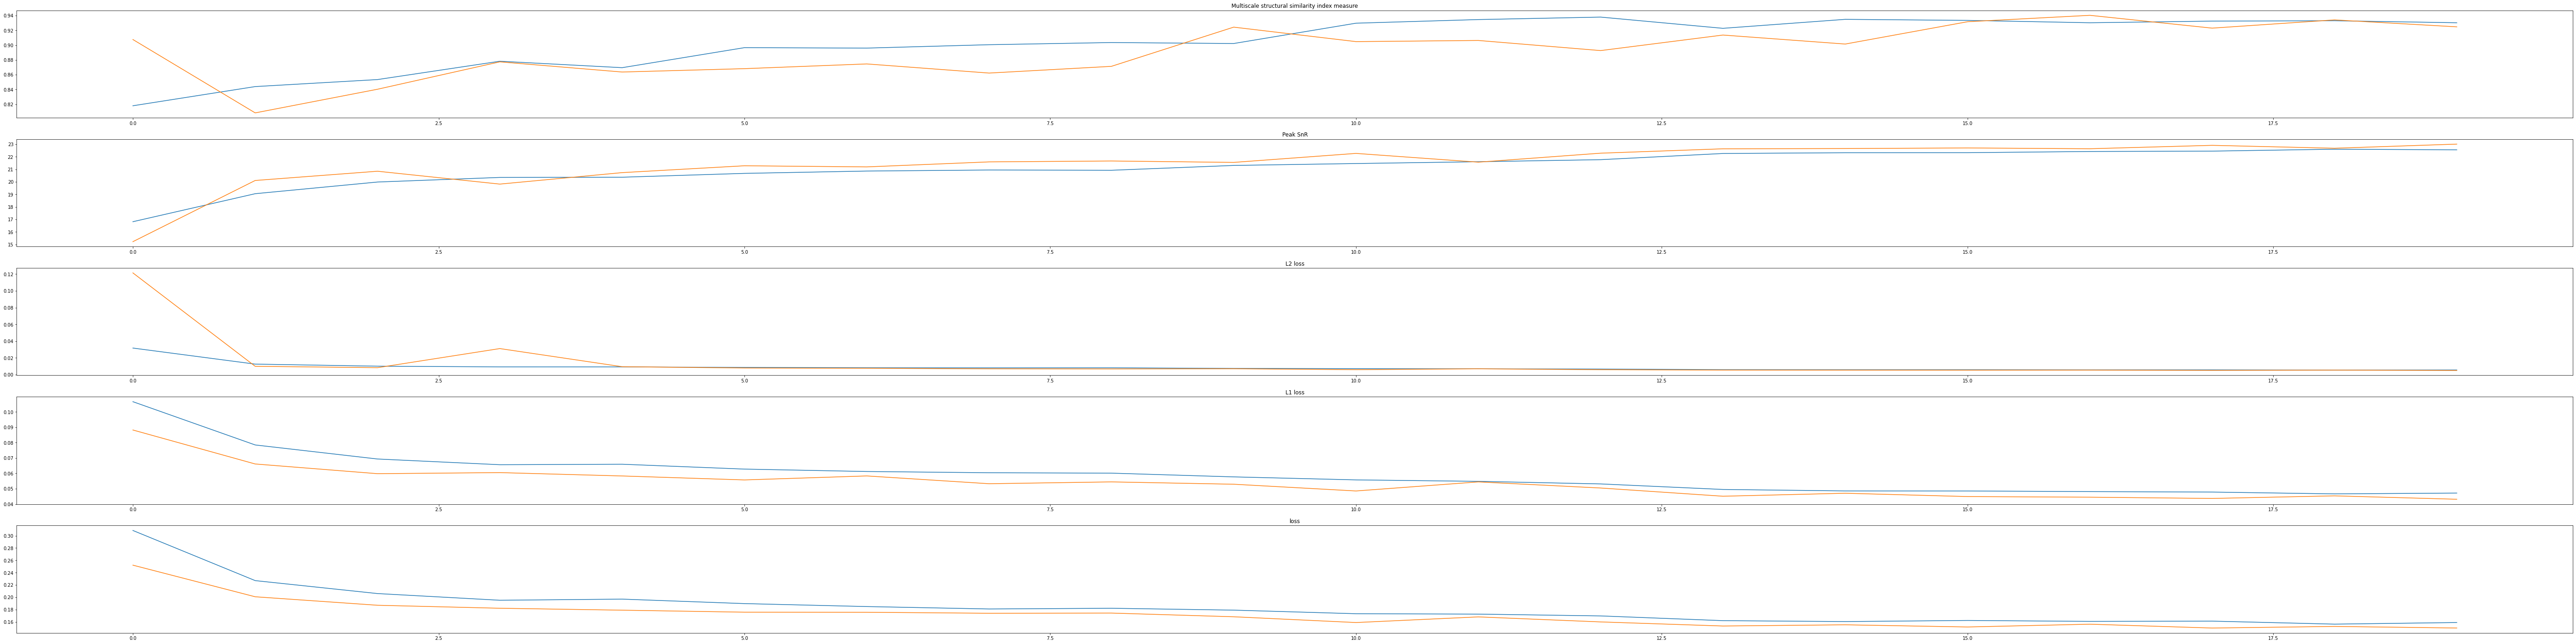

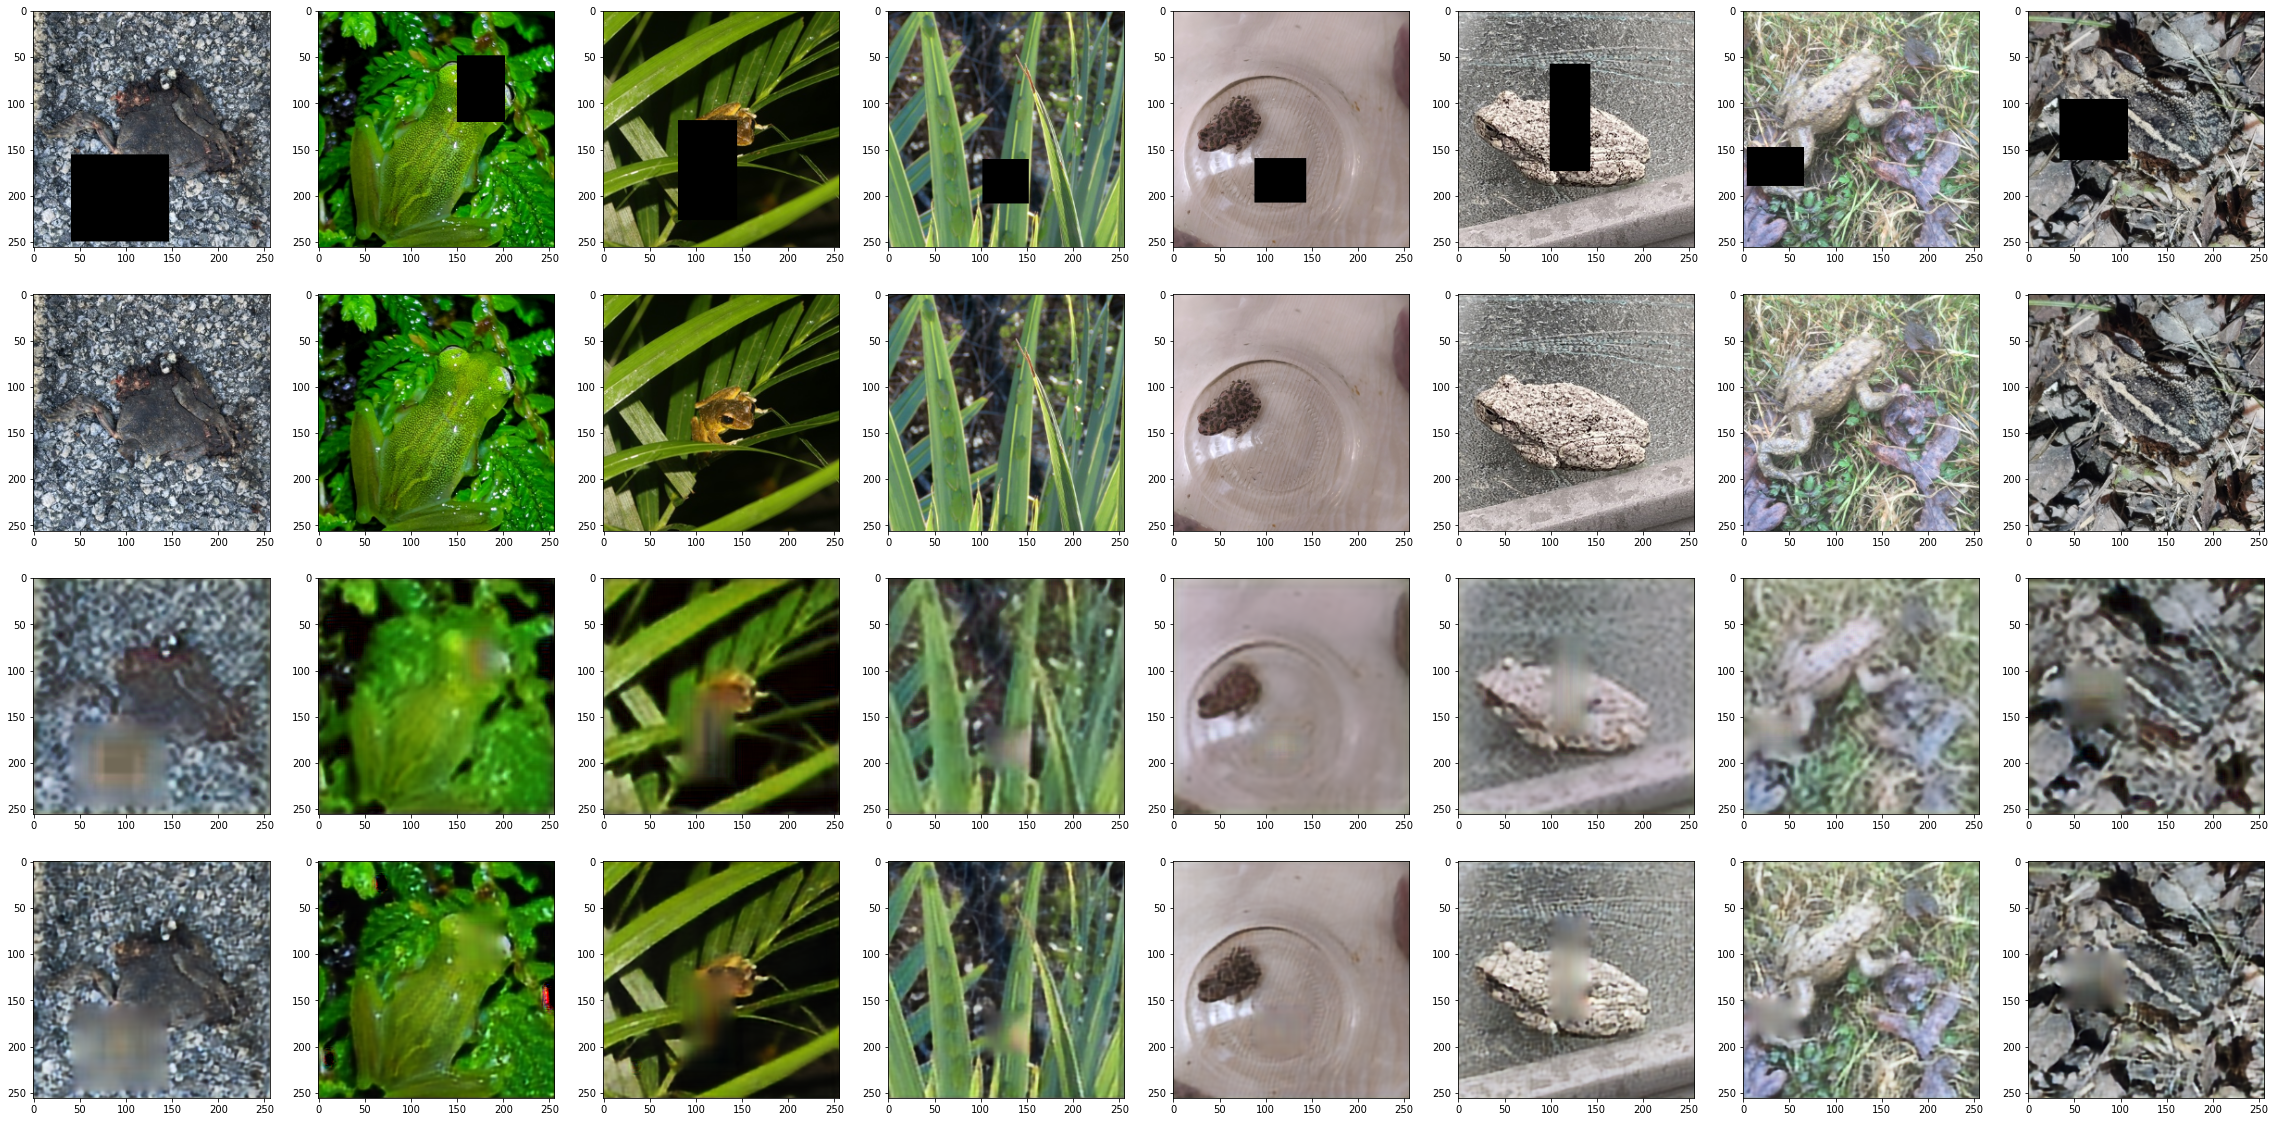

In [21]:
visualize_results(model, device, running_train_results, running_eval_results, test_dataset = validation_dataset)